# Community Detection

<hr style="border:2px solid black"> </hr>

## Notebook 01 - Create dataset for ingestion into networkx

Create a recipe graph with weighted edges based on users. Analyze the graph to detect user communities, and use the distance between communities to calculate similarity scoring.

---

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sys

In [2]:
def num_uniques(ser):
    try:
        return len(ser.unique())
    except:
        return "Not unique check-able"

In [3]:
def summarize_df(df):
    print("======DATA SUMMARY======")
    print("{} rows by {} columns".format(df.shape[0], df.shape[1]))
    print("\n======COLUMNS======")
    print(df.dtypes)
    print("\n======PREVIEW======")
    display(df.head())
    print("\n======NUMERICAL COL SUMMARY======")
    print(df.describe())
    print("\n")
    for col in df.columns:
        print("{}: {} unique values".format(col, num_uniques(df[col])))

---
### Import data

In [4]:
users = pd.read_csv('../01_DataCleansing/users_in_count2_mean4.csv') \
            .drop('ratings', axis=1)
summarize_df(users)

======DATA SUMMARY======
599009 rows by 2 columns

======COLUMNS======
user_id      int64
recipe_id    int64
dtype: object

======PREVIEW======


,user_id,recipe_id
0,0,1118
1,0,27680
2,0,32541
3,0,137353
4,0,16428



======NUMERICAL COL SUMMARY======
             user_id      recipe_id
count  599009.000000  599009.000000
mean     4450.979807   87765.758825
std      5644.504991   51419.630852
min         0.000000       0.000000
25%       480.000000   43034.000000
50%      1927.000000   87776.000000
75%      6339.000000  132193.000000
max     25075.000000  178262.000000


user_id: 25006 unique values
recipe_id: 85519 unique values


---
### Join tables and calculate percentage of shared users

In [5]:
%%time
print(time.asctime(time.localtime(time.time())))
# Create merged table with count of shared users
shared_users = users.merge(users, on='user_id', suffixes=('', '_2')) \
                    .groupby(['recipe_id', 'recipe_id_2']) \
                    .agg({'user_id':'count'}) \
                    .rename({'user_id':'shared_count'}, axis=1) \
                    .reset_index()

Thu Apr 21 10:23:24 2022
CPU times: user 2min 41s, sys: 1min 34s, total: 4min 15s
Wall time: 4min 44s


In [6]:
# Reduce dataset size by removing duplicate edges & self-joining edges
shared_users = shared_users[shared_users['recipe_id'] < shared_users['recipe_id_2']]

In [7]:
summarize_df(shared_users)

======DATA SUMMARY======
118101546 rows by 3 columns

======COLUMNS======
recipe_id       int64
recipe_id_2     int64
shared_count    int64
dtype: object

======PREVIEW======


,recipe_id,recipe_id_2,shared_count
1,0,1118,1
2,0,4446,1
3,0,5904,1
4,0,11190,1
5,0,15142,1



======NUMERICAL COL SUMMARY======
          recipe_id   recipe_id_2  shared_count
count  1.181015e+08  1.181015e+08  1.181015e+08
mean   5.919704e+04  1.186249e+05  1.084047e+00
std    4.195803e+04  4.210507e+04  4.472578e-01
min    0.000000e+00  1.400000e+01  1.000000e+00
25%    2.388100e+04  8.900700e+04  1.000000e+00
50%    5.175700e+04  1.260040e+05  1.000000e+00
75%    8.903400e+04  1.541630e+05  1.000000e+00
max    1.782560e+05  1.782620e+05  1.830000e+02


recipe_id: 85366 unique values
recipe_id_2: 85345 unique values
shared_count: 116 unique values


In [8]:
%%time
print(time.asctime(time.localtime(time.time())))
# Create table with count of total users for each recipe
recipe_counts = users.groupby('recipe_id') \
                        .agg({'user_id':'count'}) \
                        .rename({'user_id':'recipe_count'}, axis=1)

Thu Apr 21 10:30:18 2022
CPU times: user 39.8 ms, sys: 18.8 ms, total: 58.6 ms
Wall time: 60.1 ms


In [9]:
summarize_df(recipe_counts)

======DATA SUMMARY======
85519 rows by 1 columns

======COLUMNS======
recipe_count    int64
dtype: object

======PREVIEW======


,recipe_count
recipe_id,
0,2
2,2
4,2
5,3
7,15



======NUMERICAL COL SUMMARY======
       recipe_count
count  85519.000000
mean       7.004397
std       17.920144
min        2.000000
25%        2.000000
50%        3.000000
75%        6.000000
max     1091.000000


recipe_count: 269 unique values


In [10]:
%%time
print(time.asctime(time.localtime(time.time())))
# Join in individual counts and calculate percentage of users
shared_users = shared_users.merge(recipe_counts, left_on='recipe_id', right_on='recipe_id') \
                            .merge(recipe_counts, left_on='recipe_id_2', right_on='recipe_id', suffixes=('', '_2'))
shared_users['pct_users'] = shared_users['shared_count'] / (shared_users['recipe_count'] + shared_users['recipe_count_2'] - 1)

Thu Apr 21 10:30:25 2022
CPU times: user 29.2 s, sys: 24.7 s, total: 53.9 s
Wall time: 56.3 s


In [11]:
summarize_df(shared_users)

======DATA SUMMARY======
118101546 rows by 6 columns

======COLUMNS======
recipe_id           int64
recipe_id_2         int64
shared_count        int64
recipe_count        int64
recipe_count_2      int64
pct_users         float64
dtype: object

======PREVIEW======


,recipe_id,recipe_id_2,shared_count,recipe_count,recipe_count_2,pct_users
0,0,1118,1,2,5,0.166667
1,60,1118,1,4,5,0.125000
2,1066,1118,1,2,5,0.166667
3,1086,1118,1,6,5,0.100000
4,0,4446,1,2,14,0.066667



======NUMERICAL COL SUMMARY======
          recipe_id   recipe_id_2  shared_count  recipe_count  recipe_count_2  \
count  1.181015e+08  1.181015e+08  1.181015e+08  1.181015e+08    1.181015e+08   
mean   5.919704e+04  1.186249e+05  1.084047e+00  1.775030e+01    1.761069e+01   
std    4.195803e+04  4.210507e+04  4.472578e-01  4.875553e+01    5.218852e+01   
min    0.000000e+00  1.400000e+01  1.000000e+00  2.000000e+00    2.000000e+00   
25%    2.388100e+04  8.900700e+04  1.000000e+00  3.000000e+00    3.000000e+00   
50%    5.175700e+04  1.260040e+05  1.000000e+00  6.000000e+00    6.000000e+00   
75%    8.903400e+04  1.541630e+05  1.000000e+00  1.300000e+01    1.300000e+01   
max    1.782560e+05  1.782620e+05  1.830000e+02  1.091000e+03    1.091000e+03   

          pct_users  
count  1.181015e+08  
mean   8.935996e-02  
std    7.323516e-02  
min    8.756567e-04  
25%    3.571429e-02  
50%    7.142857e-02  
75%    1.250000e-01  
max    6.666667e-01  


recipe_id: 85366 unique values
reci

---
### Determine potential user count threshold

<AxesSubplot:ylabel='Frequency'>

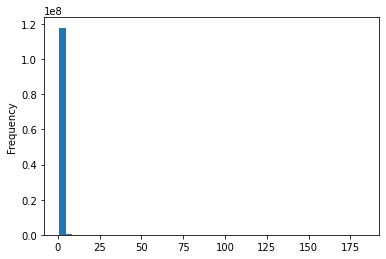

In [12]:
# Histo
shared_users['shared_count'].plot.hist(bins=50)

It appears the only option is 1

In [13]:
summarize_df(shared_users[shared_users['shared_count'] >= 2])

======DATA SUMMARY======
7465403 rows by 6 columns

======COLUMNS======
recipe_id           int64
recipe_id_2         int64
shared_count        int64
recipe_count        int64
recipe_count_2      int64
pct_users         float64
dtype: object

======PREVIEW======


,recipe_id,recipe_id_2,shared_count,recipe_count,recipe_count_2,pct_users
112,2949,5904,3,256,25,0.010714
209,903,15142,2,79,13,0.021978
210,946,15142,2,249,13,0.007663
214,1113,15142,2,17,13,0.068966
223,1504,15142,2,15,13,0.074074



======NUMERICAL COL SUMMARY======
          recipe_id   recipe_id_2  shared_count  recipe_count  recipe_count_2  \
count  7.465403e+06  7.465403e+06  7.465403e+06  7.465403e+06    7.465403e+06   
mean   5.894039e+04  1.184377e+05  2.329604e+00  4.824399e+01    4.924792e+01   
std    4.192853e+04  4.225706e+04  1.228209e+00  1.012047e+02    1.116337e+02   
min    2.000000e+00  1.090000e+02  2.000000e+00  2.000000e+00    2.000000e+00   
25%    2.399200e+04  8.893900e+04  2.000000e+00  7.000000e+00    7.000000e+00   
50%    5.150800e+04  1.261200e+05  2.000000e+00  1.500000e+01    1.500000e+01   
75%    8.891900e+04  1.539760e+05  2.000000e+00  4.100000e+01    3.900000e+01   
max    1.782240e+05  1.782620e+05  1.830000e+02  1.091000e+03    1.091000e+03   

          pct_users  
count  7.465403e+06  
mean   7.659172e-02  
std    7.397382e-02  
min    1.725626e-03  
25%    2.097902e-02  
50%    5.555556e-02  
75%    1.111111e-01  
max    6.666667e-01  


recipe_id: 66286 unique values
reci

---
Determine potential percentage of users threshold

<AxesSubplot:ylabel='Frequency'>

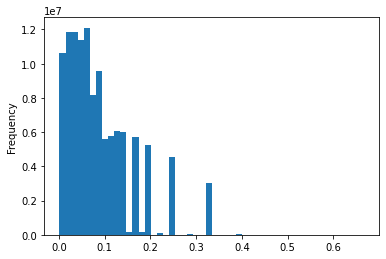

In [14]:
# Determine potential pct users threshold
shared_users['pct_users'].plot.hist(bins=50)

In [15]:
thresholds = np.arange(0.01, .11, .01)
orig_len = shared_users.shape[0]
for thresh in thresholds:
    new_len = shared_users[shared_users['pct_users'] >= thresh].shape[0]
    print("A threshold of {} reduces the row count to {}, {:.2%} of original".format(thresh, new_len, new_len/orig_len))

A threshold of 0.01 reduces the row count to 111330246, 94.27% of original
A threshold of 0.02 reduces the row count to 102116807, 86.47% of original
A threshold of 0.03 reduces the row count to 93510647, 79.18% of original
A threshold of 0.04 reduces the row count to 85122761, 72.08% of original
A threshold of 0.05 reduces the row count to 76884968, 65.10% of original
A threshold of 0.060000000000000005 reduces the row count to 66917889, 56.66% of original
A threshold of 0.06999999999999999 reduces the row count to 60157677, 50.94% of original
A threshold of 0.08 reduces the row count to 52207652, 44.21% of original
A threshold of 0.09 reduces the row count to 47468859, 40.19% of original
A threshold of 0.09999999999999999 reduces the row count to 42407536, 35.91% of original


In [16]:
# Write out full file
shared_users[['recipe_id', 'recipe_id_2', 'pct_users']].to_parquet('clustering_data_filtered')

In [17]:
# Write out file considering only more than 2 users
shared_users[shared_users['shared_count'] >= 2][['recipe_id', 'recipe_id_2', 'pct_users']].to_parquet('clustering_data_filtered_numthresh-2')

In [18]:
# Write out file considering percentage threshold of 8%
shared_users[shared_users['pct_users'] >= 0.08][['recipe_id', 'recipe_id_2', 'pct_users']].to_parquet('clustering_data_filtered_pctthresh-08')